In [210]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.models import Model

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
# Load the data
data = pd.read_csv("train.csv")

# Separate the features and the target
X, Y = data.drop(['fraude', 'index'], axis=1), data["fraude"]

In [58]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=100, stratify=Y)

In [88]:
X_train_noAnomaly = X_train[Y_train == 0]
Y_train_noAnomaly = Y_train[Y_train == 0]
X_test_withAnomalies = X_test
Y_test_withAnomalies = Y_test

In [211]:
class AnomalyDetector(Model):
    def __init__(self, l1_value=0.000001):
        super(AnomalyDetector, self).__init__()
        self.reductionDim = 8
        self.encoder = tf.keras.Sequential([
            layers.Dense(29, activation="relu" ),  
            layers.Dense(16, activation="relu"),  
            layers.Dense(self.reductionDim, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(self.reductionDim,activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(29, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [212]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [213]:
autoencoder.fit(X_train_noAnomaly, X_train_noAnomaly,
                epochs=30,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping])

Epoch 1/30
5598/5598 [==============================] - 10s 2ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/30
5598/5598 [==============================] - 8s 1ms/step - loss: 9.7874e-04 - val_loss: 9.5117e-04
Epoch 3/30
5598/5598 [==============================] - 7s 1ms/step - loss: 8.9767e-04 - val_loss: 9.2514e-04
Epoch 4/30
5598/5598 [==============================] - 7s 1ms/step - loss: 8.8204e-04 - val_loss: 9.1456e-04
Epoch 5/30
5598/5598 [==============================] - 7s 1ms/step - loss: 8.6610e-04 - val_loss: 8.8227e-04
Epoch 6/30
5598/5598 [==============================] - 7s 1ms/step - loss: 7.5120e-04 - val_loss: 7.4508e-04
Epoch 7/30
5598/5598 [==============================] - 7s 1ms/step - loss: 6.9770e-04 - val_loss: 7.2972e-04
Epoch 8/30
5598/5598 [==============================] - 7s 1ms/step - loss: 6.9092e-04 - val_loss: 7.2358e-04
Epoch 9/30
5598/5598 [==============================] - 8s 1ms/step - loss: 6.8801e-04 - val_loss: 7.1863e-04
Epoch 10/30
5598/

KeyboardInterrupt: 

In [200]:
X_test_WA_pred = autoencoder.predict(X_test_withAnomalies)
mse = np.mean(np.power(X_test_withAnomalies - X_test_WA_pred, 2), axis=1)

2404/2404 [==============================] - 2s 677us/step


In [201]:
print(f'Average reconstruction error (train): {np.mean(mse)}')

Average reconstruction error (train): 0.0006864483185918821


Text(0, 0.5, 'Frequency')

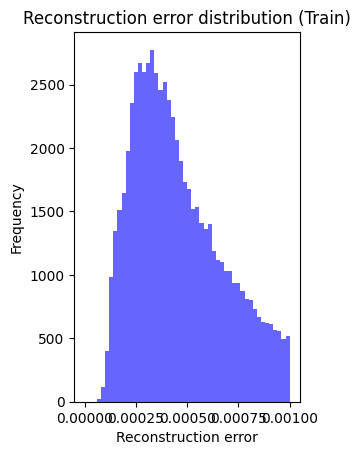

In [202]:
plt.subplot(1, 2, 1)
plt.hist(mse, bins=50, alpha=0.6,range=(0,0.001), color='blue')
plt.title('Reconstruction error distribution (Train)')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')

In [203]:
thresholds = np.linspace(0, 0.1, 100)
f1_scores = []
for thresh in thresholds:
    preds = [1 if e > thresh else 0 for e in mse]
    f1 = f1_score(Y_test, preds)
    f1_scores.append(f1)

In [204]:
max_f1 = max(f1_scores)
max_f1_threshold = thresholds[f1_scores.index(max_f1)]

In [205]:
max_f1_threshold

0.00909090909090909

In [206]:
predictions = [1 if e > max_f1_threshold else 0 for e in mse]

In [207]:
(len(predictions)),len(Y_test_withAnomalies)

(76898, 76898)

In [208]:
accuracy = accuracy_score(Y_test_withAnomalies, predictions)
f1 = f1_score(Y_test_withAnomalies, predictions)
precision = precision_score(Y_test_withAnomalies, predictions)
recall = recall_score(Y_test_withAnomalies, predictions)

print(f'Maximum F1 Score: {max_f1}')
print(f'Best Threshold: {max_f1_threshold}')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Maximum F1 Score: 0.5644599303135889
Best Threshold: 0.00909090909090909
Accuracy: 0.9983744700772452
F1 Score: 0.5644599303135889
Precision: 0.525974025974026
Recall: 0.6090225563909775


In [162]:
predictionsDf = pd.DataFrame(X_test_WA_pred)

In [168]:
predictionsDf["Mse"] = mse
predictionsDf["Prediction"] = predictions
predictionsDf["True"] = list(Y_test_withAnomalies)

In [171]:
predictionsDf.to_csv("predictions.csv")